# Contents
- Electron Population
  - NORM IS A PARAMETER THIS TIME
- Synchrotron Emission
  - None of these work...
- Coma Data
  - Fit a simple power law 
  
  
I will do a fit to the synchrotron function but I can't use the norm as a parameter unless I figure out how to manually write the ClusterEmission synchrotron! 


In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

   # Define Cluster object: COMA

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/Users/adam/Desktop/test')

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.


# Setting up Models
For Primary electrons use a simple power law

In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value


In [4]:
#Set some random stolen models for the primary electrons
clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
                             #'ExponentialCutoffPowerLaw','Index':3.3, 'CutoffEnergy':1e7*u.keV}
                           
                        
## You can try building a model incorporating the energy losses from sync and IC!


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = clust.Epmin 
Eemax = clust.Epmax

Getting the minimal proton energy
Getting the maximal proton energy


## Electron Functions
Norm, A, is a parameter now

In [5]:



clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl , en): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu


def cre1_2d(A = 1/u.GeV/u.cm**3, cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')



def density_cre1_profile(A = 1/u.GeV/u.cm**3 , rad = np.logspace(0,4,100)*u.kpc, Emin = None, Emax = None):
    
    if Emin is None:
        Emin = (const.m_e*const.c**2).to('GeV')
    if Emax is None:
        Emax = clust._Epmax
    
    #Define energy range
    eng = model_tools.sampling_array(Emin, Emax,NptPd = clust._Npt_per_decade_integ, unit = True)
    
    #2D differntial spectrum
    dN_dEdV = cre1_2d(A, clust, eng, rad)
    
    #Integrate the diffferential spectrum 
    prof = (model_tools.trapz_loglog(dN_dEdV, eng, axis = 0)).to('cm-3')
    
    return rad, prof 

## They work 

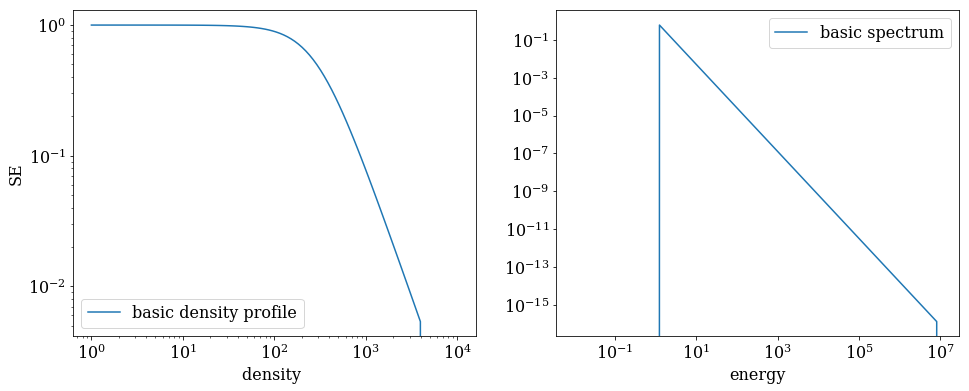

In [92]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV


# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a ,b = get_normed_density_cre1_profile(clust, radius)
plt.loglog(a,b, label='basic density profile')

plt.xlabel('density ')
plt.ylabel('SE')
plt.legend()


plt.subplot(122)
c, d = get_normed_spectrum_cre1(clust,energy)
plt.loglog(c,d,label = 'basic spectrum')
plt.xlabel('energy')
plt.legend()

# Risky Sync Attempt - NONE WORKS

In [7]:
from scipy.special import cbrt


def Gtilde( x):
        """
        Useful equation. Aharonian, Kelner, Prosekin 2010 Eq. D7
        Taken from Naima.
        
        Factor ~2 performance gain in using cbrt(x)**n vs x**(n/3.)
        Invoking crbt only once reduced time by ~40%
        """
        cb = cbrt(x) # x**1/3
        gt1 = 1.808 * cb / np.sqrt(1 + 3.4 * cb ** 2.0)
        gt2 = 1 + 2.210 * cb ** 2.0 + 0.347 * cb ** 4.0
        gt3 = 1 + 1.353 * cb ** 2.0 + 0.217 * cb ** 4.0
        
        return gt1 * (gt2 / gt3) * np.exp(-x)
    

In [71]:
def synchrotron(cl, Ephoton_input, radius, B=1.0*u.uG, A = 1/u.GeV/u.cm**3):
        
        NptEePd = 100
        #Electron energy
        Eemin = (const.m_e *const.c**2).to_value('GeV')
        Eemax = clust.Epmax
        Eemax = Eemax.to_value('GeV')
        Ee = np.logspace(np.log10(Eemin), np.log10(Eemax), 100)
        #np.logspace(np.log10(Eemin), np.log10(Eemax), int(NptEePd*(np.log10(Eemax/Eemin))))

        # Check input photons
        Ephoton = Ephoton_input.to('eV')
        if type(Ephoton) == float: Ephoton = np.array([Ephoton])
#Eemin = clust.Epmin 
#Eemax = clust.Epmax
      
        gamma = (Ee/(const.m_e*const.c**2).to_value('GeV')) # 1D
        ampli = np.sqrt(3)/(8*np.pi**2)*(const.e.value*const.e.unit)**3/(const.eps0*const.m_e*const.c*const.hbar)

        #---------- Case of integrated quantities, no radius
        # Get the electron distribution
        Je = cre1_2d( A , cl , Ee*u.GeV, radius).to_value('GeV-1 cm-3').T*u.GeV**-1
        #Je = Je*u.GeV**-1

        # Get the normalization function (1D: Ephot)
        func = ampli * B / Ephoton
        
        # Get the critical energy and energy ratio
        Ec = (3.0/2)*gamma**2*const.e.value*const.e.unit*B*const.hbar / (const.m_e) # 1D: Eelec
        EphotEc = Ephoton.to_value('GeV') / np.vstack(Ec.to_value('GeV')) # 2D: photon energy, electron energy

        # Compute integrand
        dNphot_dEdt = func * Gtilde(EphotEc)
        
        # Integrate over electron energy
        dNphot_dEdt = model_tools.trapz_loglog(np.vstack(Je.value)*Je.unit * dNphot_dEdt, Ee*u.GeV, axis=0)

        # Get the output
        output = dNphot_dEdt.to('GeV-1 s-1')

        return output 

## Synchotron Emission

In [72]:
 def get_rate_synchrotron(self, energy=np.logspace(-9,-2,100)*u.eV, radius=np.logspace(0,4,100)*u.kpc):
        """
        Compute the synchrotron density as dN/dEdVdt = f(E, r)
        
        Parameters
        ----------
        - energy (quantity) : the physical energy of synchrotron photons
        - radius (quantity): the physical 3d radius in units homogeneous to kpc, as a 1d array

        Outputs
        ----------
        - dN_dEdVdt (np.ndarray): the differntial production rate

        """

        # In case the input is not an array
        energy = model_tools.check_qarray(energy, unit='eV')
        radius = model_tools.check_qarray(radius, unit='kpc')

        # Get the magnetic field
        radius, B   = self.get_magfield_profile(radius)
        
        # Parse the CRe distribution: returns call function[rad, energy] amd returns f[rad, energy]
        def Je(rad, eng): return self.get_cre_2d(eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T

        # Define the model
        model = cluster_electron_emission.ClusterElectronEmission(Je,
                                                                  Eemin=(const.m_e*const.c**2).to('GeV'),
                                                                  Eemax=self._Epmax,
                                                                  NptEePd=self._Npt_per_decade_integ)
        
        # Extract the spectrum: what is long is evaluating Je inside the code

In [73]:
def rate_sync(A = (1/u.GeV/u.cm**3), cl = clust, energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
        
    rate = synchrotron(cl, energy, radius, B, A).T
    
    return rate.to('GeV-1 cm-3 s-1')



from ClusterModel.ClusterTools import cluster_electron_emission as emi
def Rrate_sync(A = (1/u.GeV/u.cm**3), cl = clust, energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2( rad, eng): return cre1_2d( A = A , cl = cl, en= eng*u.GeV, rd = rad*u.kpc).to_value('GeV-1 cm-3').T
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')



def sync_spectrum(A = (1/u.GeV/u.cm**3), cl = clust, freq = np.logspace(-3,2,100)*u.GHz, Rmin = None, Rmax = None):
    
    
    #Get energy
    energy = (const.h*freq).to('eV')
    
    #Determine boundaries
    if Rmin is None:
        Rmin = clust._Rmin
    if Rmax is None:
        Rmax = clust._R500
        
        
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
    dNdEdVdt = rate_sync(A, cl, energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')





# Data

In [96]:
# Radio total flux [Thierbach et al (2003)]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy


In [97]:
#Primary
#dat_freq, spectrum = sync_spectrum(dat_freq)


### Just plot the data along with a powerlaw

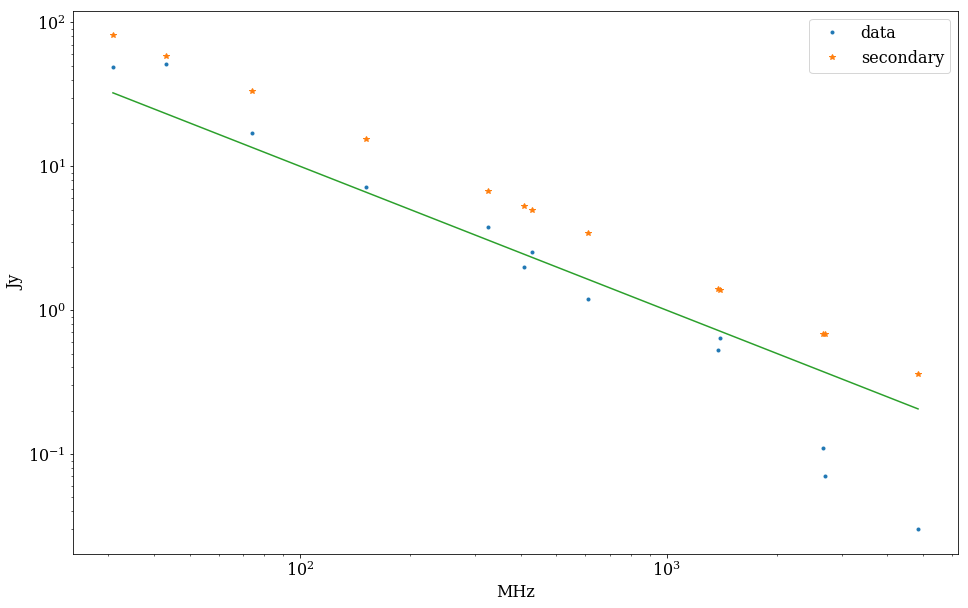

In [102]:
#Secondary Electrons
bid, s1 = clust.get_synchrotron_spectrum(dat_freq, Rmin=None, Rmax=None, type_integral='spherical', Rmin_los=None, 
                                   NR500_los=5.0, Cframe=False)

def trialfunc(x):
    return 10**3*(x)**(-1)

trial = trialfunc(dat_freq)


plt.figure(figsize=(15,10))
##DATA
plt.loglog(dat_freq,dat_flux,".", label = "data")
#SECONDARY
plt.loglog(dat_freq, s1, "*", label = "secondary")

plt.loglog(dat_freq, trial)


plt.xlabel(dat_freq.unit)
plt.ylabel((s1).unit)
plt.legend()
plt.show()


# Fitting to COMA

# Simple
Just fit some simple power law, for sanity check

In [28]:
from scipy import optimize


def fitfunc(x, a, b):
    return a*(x)**b

params, params_covariance = optimize.curve_fit(fitfunc, dat_freq, dat_flux,
                                               p0=[2, 2])

print(params)

[ 2.27834835e+03 -1.08423216e+00]


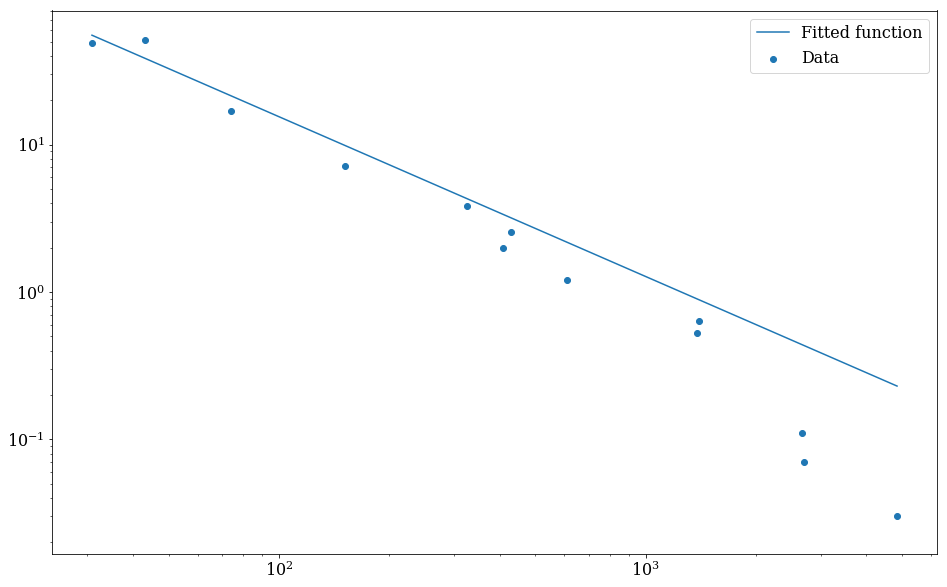

In [30]:
plt.figure(figsize=(15, 10))
plt.scatter(dat_freq, dat_flux, label='Data')
plt.loglog(dat_freq, fitfunc(dat_freq, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

## Notes
Not bad! 

# Try Harder 
Leastsq
- It doesnt work 

In [85]:

import matplotlib.gridspec as gridspec

def fitfunc2(p, x):
    return p[0]*(x)**p[1]
def residual2(p, x, y, dy):
    return (fitfunc2(p, x)-y)/dy

y = dat_flux
x = dat_freq
p02 = [ 2.27834835e+03,-1.08423216e+00]
dy = dat_err
pf2, cov2, info2, mesg2, success2 = optimize.leastsq(residual2, p02, args = (x, y, dy), full_output=1)
pf2_f, pf2_a = pf2
if success2 <= 4:
    print("Fit Converged")
    chisq2 = sum(info2["fvec"]*info2["fvec"])
    dof2 = len(x)-len(pf2)
    pferr2 = [np.sqrt(cov2[i,i]) for i in range(len(pf2))]
    diff = np.array(y - fitfunc2(pf2, x))

    
    
    f, (ax1, ax2) = plt.subplots(nrows =2,sharex = True, figsize = (30,15),gridspec_kw={'height_ratios': [4,1]} )


    yerr = dy
    ax1.errorbar(x, y, yerr, fmt='k.', label = 'Data')
    T = np.linspace(x.min(), x.max(), 2000)
    ax1.plot(T, fitfunc2(pf2, T), 'r-', label = 'Fit')
    
   # ax1.loglog(T, fitfunc2(pf2, T), 'r-', label = 'Fit')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    ax1.set_title('Spectrum', fontsize = 30)
    ax1.set_xlabel('GHz', fontsize = 20)
    ax1.set_ylabel('Jy', fontsize = 20)
    ax1.tick_params(axis = 'both', which = "major", labelsize = 18)
    ax1.legend(fontsize = 20)
    
    
    
   # ax3 = fig2.add_subplot(gs[1])
    ax2.errorbar(x, diff, yerr = diff ,fmt="o")
    ax2.axhline(color="gray", zorder=-1)
    ax2.set_xlabel('GHz', fontsize = 20 )
    ax2.set_ylabel('residuals', fontsize = 20)
    ax2.tick_params(axis = 'both', which = "major", labelsize = 18)

    #ax2.set_ylim(-20, 20)
    #ax2.set_yticks((-20, 0, 20))
    

else:
    print('Fit did not converge')
    print(mesg2)


UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions